## Import Libraries

In [4]:
#imports
import os
import torch
#import torchvision
import torch.nn as nn
#import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import Parameter
from torch.autograd import Variable
import math

ModuleNotFoundError: No module named 'PIL'

### Task for Increaing Performance

1. Built in VGG, RESNET34, RESNET18, RESNET50 (FZ) ✔

2. Dense Layer ✔

3. Weights and Biases Saved ❌

4. Freezing Layer -- VGG (SGD, ADAM) ✔

5. Dropout -- p = 0.25 ( Result: Decrease Performance) ✔

6. optimizer -- SGD works better ✔

7. Learning rate -- 0.01 works better ✔

8. margin decrease from 0.35 to 0.1 which gives 45.28 accuracy ✔

9. s=2 works better ✔

10. Batch size 100 works better than 32,128 ✔

11. Activation changed ELU, Relu works better than ELU ✔

12. pre-trained - True works better ✔

13. BatchNorm1d works better ✔

14. Laplacian processing is done but doesn't improve result  ✔

15. Center Loss code is implemented but doesn't converge ✔

16. Data is normalized ✔

17. At m = 2, SphereFace performs 48.97% accuracy with (512-256 layers) ✔ 




### Data Loading

In [35]:
#directories

BDSL_TRAIN = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/BDSL/BDSL_split/train'
BDSL_VAL = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/BDSL/BDSL_split/test'
BDSL_TEST = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/BDSL/BDSL_split/test'

ISHARA_AUGMENTED_TRAIN = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_augmentated/Isharalipi_augmentated_split/train'

ISHARA_AUGMENTED_VAL = 'D:/Sign language Dataset/Final/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_augmentated/Isharalipi_augmentated_split/val'
ISHARA_AUGMENTED_TEST = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_augmentated/Isharalipi_augmentated_split/test'

ISHARA_MAIN = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_original/Isharalipi_original_main'

In [36]:
TRAIN_DIRECTORY = ISHARA_AUGMENTED_TRAIN
VAL_DIRECTORY = BDSL_VAL
TEST_DIRECTORY = BDSL_TEST

In [37]:
img_transform = transforms.Compose([transforms.Resize((64,64)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485,0.456,0.406],
                                    std = [0.229,0.224,0.225])])

train_data = ImageFolder(TRAIN_DIRECTORY, transform=img_transform)
val_data = ImageFolder(VAL_DIRECTORY, transform=img_transform)
test_data = ImageFolder(TEST_DIRECTORY, transform=img_transform)

In [38]:
# Device configuration
device = torch.device('cuda')

### Hyperparameters

In [39]:
# Hyper-parameters 
num_epochs = 15
batch_size = 100
learning_rate = 0.01

load_model = False

In [40]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2,shuffle=True, num_workers=4, pin_memory=True)

In [41]:
label = torch.tensor([])
img, label = test_data[5]
print(img.shape, label)

torch.Size([3, 64, 64]) 0


In [42]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

18968
2416
2416


In [43]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\anaconda3\python.exe -m pip install --upgrade pip' command.


## MODEL 

In [44]:
#load pretrained model
import torchvision.models as models

#model = models.resnet18(pretrained=True)
#model = models.alexnet(pretrained=False)
# model = models.squeezenet1_0(pretrained=True)
model = models.vgg16(pretrained=True)
# model = models.densenet161(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.shufflenet_v2_x1_0(pretrained=False)
# model = models.mobilenet_v2(pretrained=False)
# model = models.resnext50_32x4d(pretrained=True)
# model = models.wide_resnet50_2(pretrained=True)
# model = models.mnasnet1_0(pretrained=True)
#model = models.resnet50(pretrained=True)
#in_features
resnet18 = 512
alexnet = 256*6*6
# squeezenet1_0 = 1000
vgg16 = 512*7*7
# densenet161
# inception_v3
googlenet = 1000
shufflenet_v2_x1_0 = 1000
mobilenet_v2 = 1280
# resnext50_32x4d = 1000
# wide_resnet50_2 = 1000
# mnasnet1_0 = 1000
model 

from torchsummary import summary

summary(model, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─ReLU: 2-2                         [-1, 64, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 64, 64, 64]          36,928
|    └─ReLU: 2-4                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 128, 32, 32]         73,856
|    └─ReLU: 2-7                         [-1, 128, 32, 32]         --
|    └─Conv2d: 2-8                       [-1, 128, 32, 32]         147,584
|    └─ReLU: 2-9                         [-1, 128, 32, 32]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 256, 16, 16]         295,168
|    └─ReLU: 2-12                        [-1, 256, 16, 16]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─ReLU: 2-2                         [-1, 64, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 64, 64, 64]          36,928
|    └─ReLU: 2-4                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 128, 32, 32]         73,856
|    └─ReLU: 2-7                         [-1, 128, 32, 32]         --
|    └─Conv2d: 2-8                       [-1, 128, 32, 32]         147,584
|    └─ReLU: 2-9                         [-1, 128, 32, 32]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 256, 16, 16]         295,168
|    └─ReLU: 2-12                        [-1, 256, 16, 16]      

In [45]:
#RESNET

# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(
#         in_features=2048,
#         out_features=512
#     ),
#     nn.ReLU(inplace=True),
#     nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
#     torch.nn.Linear(
#         in_features=512,
#         out_features=256
#     ),
#     nn.ReLU(inplace=True),
#     nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
#     nn.Linear(in_features=256, out_features=128, bias=True),
# )
                      

In [46]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
# for param in model.parameters():
#     param.requires_grad = False

# model.classifier = nn.Sequential(nn.Linear(in_features=vgg16, out_features=1000, bias=True),
#                                  nn.ReLU(inplace=True),
                               
#                                  nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True),
#                                  nn.Linear(in_features=1000, out_features=256, bias=True),
#                                  nn.ReLU(inplace=True),
                                 
#                                  nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
#                                  nn.Linear(in_features=256, out_features=128, bias=True),
#                                  ) 

for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(nn.Linear(in_features=vgg16, out_features=512, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
                                 nn.Linear(in_features=512, out_features=256, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
                                 nn.Linear(in_features=256, out_features=256, bias=True),
                            )
model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loss Function

In [48]:
class AddMarginProduct(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta) - m
    """

    def __init__(self, in_features, out_features, s=1, m=0.10):
        super(AddMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features)).cuda()
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device='cuda')
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output


In [49]:
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [50]:
# criterion = AngularSoftmaxWithLoss()
criterion = nn.CrossEntropyLoss()
metric_fc = AddMarginProduct(256, 35)

optimizer = torch.optim.Adadelta([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                    lr=0.01, weight_decay=0.005)

## Train Loop

In [51]:

def train(num_epochs):
    
    
    print('Starting Training..')
    for e in range(0,num_epochs):
        
            
        print('='*20)
        print(f'Starting epoch {e + 1}/{num_epochs}')
        print('='*20)
        
        train_loss = 0
        
        model.train().to(device)
        
        for train_step, (images, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device).long()
            
            feature = model(images)
            output = metric_fc(feature,labels)
            
            loss = criterion(output, labels)
            
            loss.backward(retain_graph = True)
            optimizer.step()
            
            train_loss += loss.item()
            
            if (train_step) % 100 == 0:
                print ("Evaluating at step", train_step)
                print (f'Epoch [{e+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
            

        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')

In [52]:
train(num_epochs)

Starting Training..
Starting epoch 1/15
Evaluating at step 0
Epoch [1/15], Loss: 3.6604
Evaluating at step 100
Epoch [1/15], Loss: 3.3417
Training Loss: 3.3880
Starting epoch 2/15
Evaluating at step 0
Epoch [2/15], Loss: 3.2546
Evaluating at step 100
Epoch [2/15], Loss: 3.1592
Training Loss: 3.1712
Starting epoch 3/15
Evaluating at step 0
Epoch [3/15], Loss: 3.1149
Evaluating at step 100
Epoch [3/15], Loss: 3.0753
Training Loss: 3.0638
Starting epoch 4/15
Evaluating at step 0
Epoch [4/15], Loss: 3.0186
Evaluating at step 100
Epoch [4/15], Loss: 2.9862
Training Loss: 2.9878
Starting epoch 5/15
Evaluating at step 0
Epoch [5/15], Loss: 2.9509
Evaluating at step 100
Epoch [5/15], Loss: 2.9324
Training Loss: 2.9308
Starting epoch 6/15
Evaluating at step 0
Epoch [6/15], Loss: 2.9033
Evaluating at step 100
Epoch [6/15], Loss: 2.8752
Training Loss: 2.8852
Starting epoch 7/15
Evaluating at step 0
Epoch [7/15], Loss: 2.8677
Evaluating at step 100
Epoch [7/15], Loss: 2.8459
Training Loss: 2.8497


## Test Function 

In [53]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(model, test_loader, test_data):
    
    model.eval()
    all_labels = torch.tensor([],dtype=torch.int64).to(device)
    all_preds = torch.tensor([],dtype=torch.int64).to(device)
    acc = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).int()
            output = model(data)
            #print(output.shape)
            
            output1 = metric_fc(output,labels)
            m = nn.LogSoftmax()
            
            outputs = m(output1)
            #print(outputs.shape)
            
            _, pred = torch.max(outputs, 1)
            
            #print(pred)
            
            acc += sum((pred == labels)).cpu().numpy()
            preds = torch.argmax(outputs,1)
            output1 = output1.cpu()
            #labels = labels.cpu().numpy()
            all_labels = torch.cat((all_labels, labels),dim=0)
            #preds = preds.cpu().numpy()
            all_preds = torch.cat((all_preds, preds),dim=0)
            #print(labels)
            #print(preds)
    
            
            
    acc = (acc/len(test_data))*100
    print(f"acc = {acc}")
    return all_labels,all_preds
   
        

In [54]:
test(model, train_dl, train_data)

<ipython-input-53-39c70374b301>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 100.0


(tensor([17, 13, 31,  ..., 20,  5, 17], device='cuda:0'),
 tensor([17, 13, 31,  ..., 20,  5, 17], device='cuda:0'))

In [55]:
test(model, val_dl, val_data)

<ipython-input-53-39c70374b301>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 43.83278145695364


(tensor([10, 18, 25,  ..., 34, 32, 17], device='cuda:0'),
 tensor([10, 17, 13,  ..., 34, 32, 18], device='cuda:0'))

In [56]:
test(model, test_dl, test_data)

<ipython-input-53-39c70374b301>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 43.83278145695364


(tensor([ 0, 25, 30,  ..., 30, 18, 16], device='cuda:0'),
 tensor([22,  7, 30,  ..., 30, 18, 16], device='cuda:0'))

In [57]:
train_labels, train_preds = test(model, test_dl, test_data)
print(train_preds)
print(train_labels)
train_labels.shape

<ipython-input-53-39c70374b301>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 43.83278145695364
tensor([ 9,  8, 20,  ..., 16,  0,  1], device='cuda:0')
tensor([12,  8, 32,  ..., 16,  5,  1], device='cuda:0')


torch.Size([2416])

In [58]:
# print(train_preds.requires_grad)
train_labels = train_labels.cpu()
train_preds = train_preds.cpu()


In [59]:
 stacked = torch.stack(
    (
        train_labels,train_preds
    )
    ,dim=1
)
stacked.shape

torch.Size([2416, 2])

In [60]:
stacked

tensor([[12,  9],
        [ 8,  8],
        [32, 20],
        ...,
        [16, 16],
        [ 5,  0],
        [ 1,  1]])

In [61]:
# stacked[0].tolist()

In [62]:
cmt = torch.zeros(35,35,dtype = torch.int64)
cmt.shape

torch.Size([35, 35])

In [63]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
cmt

tensor([[22,  0,  7,  ...,  3,  0,  0],
        [ 2,  4,  0,  ...,  1,  0,  0],
        [12,  0, 43,  ...,  8,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 52,  0,  0],
        [ 0,  0,  0,  ..., 11, 29,  2],
        [ 0,  0,  0,  ...,  1,  8, 55]])

In [64]:
cm = confusion_matrix(train_labels, train_preds)
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[22,  0,  7, ...,  3,  0,  0],
       [ 2,  4,  0, ...,  1,  0,  0],
       [12,  0, 43, ...,  8,  0,  0],
       ...,
       [ 0,  0,  0, ..., 52,  0,  0],
       [ 0,  0,  0, ..., 11, 29,  2],
       [ 0,  0,  0, ...,  1,  8, 55]], dtype=int64)

## Confusion Matrix

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[22,  0,  7,  ...,  3,  0,  0],
        [ 2,  4,  0,  ...,  1,  0,  0],
        [12,  0, 43,  ...,  8,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 52,  0,  0],
        [ 0,  0,  0,  ..., 11, 29,  2],
        [ 0,  0,  0,  ...,  1,  8, 55]])


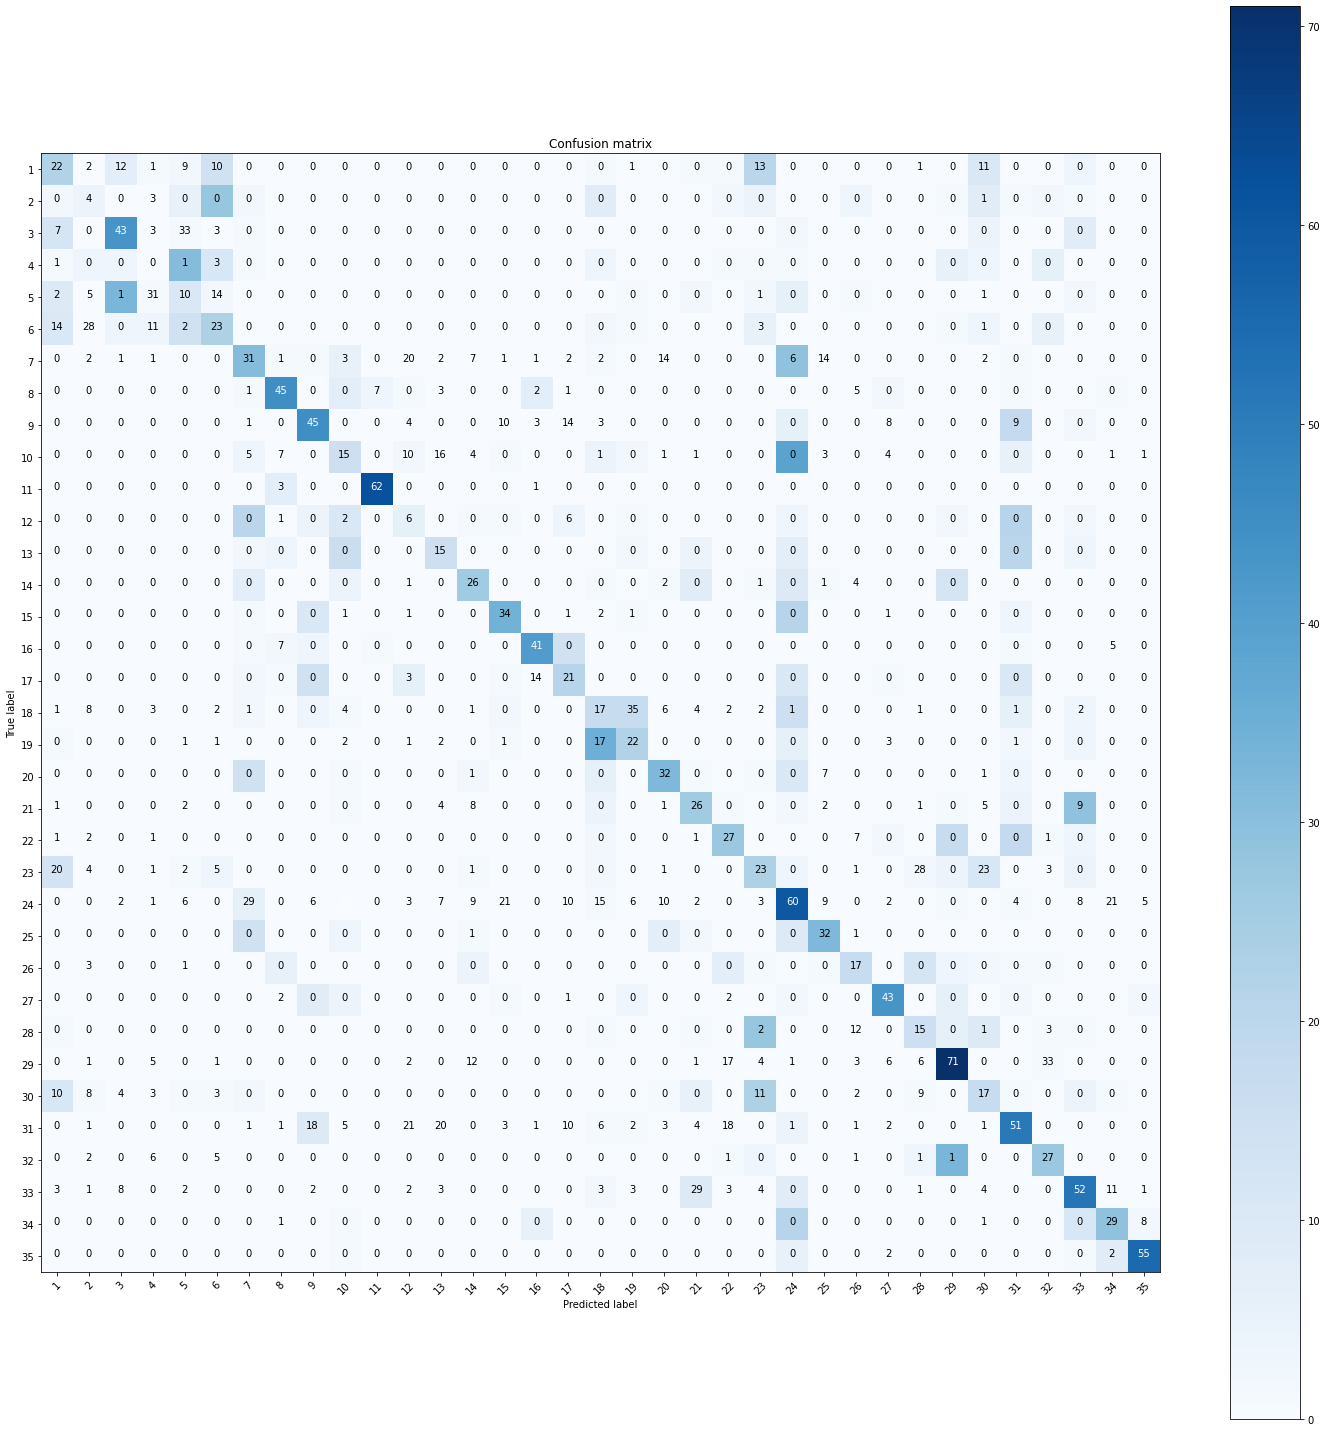

In [66]:
labels_names=["1", "2","3","4","5",
            "6", "7","8","9","10",
            "11", "12","13","14","15",
            "16", "17","18","19","20",
            "21", "22","23","24","25",
            "26", "27","28","29","30",
            "31", "32","33","34","35"]

plt.figure(figsize=(20,20))
fig = plot_confusion_matrix(cmt, labels_names)


plt.savefig('output.png', dpi=500)